In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets

import torchvision
from torchvision import transforms

import torch.nn.functional as F
import torchvision.transforms.functional as TF

from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import time
import nibabel as nib

from skimage import io, transform

np.random.seed(108)

plt.style.use('default')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

visualize = False

ModuleNotFoundError: No module named 'skimage'

In [4]:
!conda install -c conda-forge -y scikit-image

| 

# Self supervised pipeline

## Trying patches

In [2]:
from PIL import Image

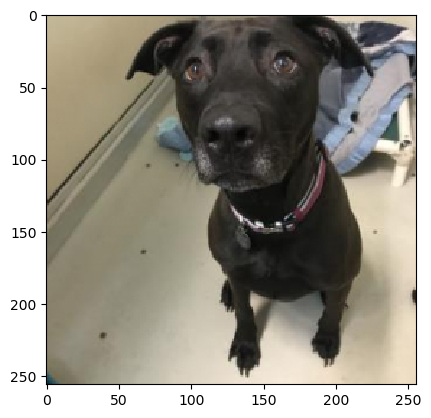

In [3]:
image = Image.open("dog.jpg")
image = np.array(image)
plt.imshow(image)
plt.show()

In [15]:
image.shape[0]

256

offset_x: 46, offset_y: 46
start_grid_x: 35, start_grid_y: 23
loc: 1, (tempx, tempy): (1, 2)
patch_x: 35, patch_y: 103


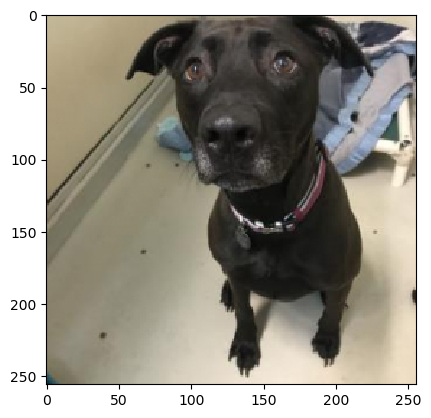

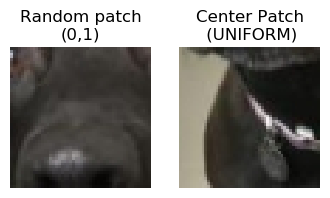

In [16]:
patch_dim = 50
gap = 30

# if offset is posi
offset_x, offset_y = image.shape[0] - (patch_dim*3 + gap*2), image.shape[1] - (patch_dim*3 + gap*2)
print('offset_x: {}, offset_y: {}'.format(offset_x, offset_y))

start_grid_x, start_grid_y = np.random.randint(0, offset_x), np.random.randint(0, offset_y)
print('start_grid_x: {}, start_grid_y: {}'.format(start_grid_x, start_grid_y))


patch_loc_arr = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)]
loc = np.random.randint(len(patch_loc_arr))
tempx, tempy = patch_loc_arr[loc]
print('loc: {}, (tempx, tempy): ({}, {})'.format(loc, tempx, tempy))

patch_x_pt = start_grid_x + patch_dim * (tempx-1) + gap * (tempx-1)
patch_y_pt = start_grid_y + patch_dim * (tempy-1) + gap * (tempy-1)
print('patch_x: {}, patch_y: {}'.format(patch_x_pt, patch_y_pt))

plt.imshow(image)
plt.show()

plt.subplots(figsize=(4,4))
plt.subplot(121)
plt.imshow(image[patch_x_pt:patch_x_pt+50, patch_y_pt:patch_y_pt+50])
plt.title('Random patch\n' +'('+ str(patch_loc_arr[loc][0]-1)+','+str(patch_loc_arr[loc][1]-1)+')')
plt.axis('off')

# Get the center patch (uniform across all the images)
plt.subplot(122)
patch_x_pt = start_grid_x + patch_dim * (2-1) + gap * (2-1)
patch_y_pt = start_grid_y + patch_dim * (2-1) + gap * (2-1)
plt.imshow(image[patch_x_pt:patch_x_pt+50, patch_y_pt:patch_y_pt+50])
plt.title('Center Patch\n (UNIFORM)')
plt.axis('off')
plt.show()


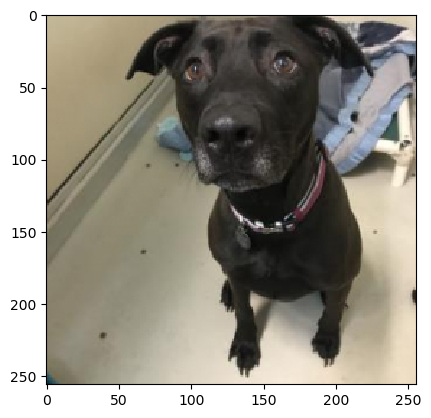

[]

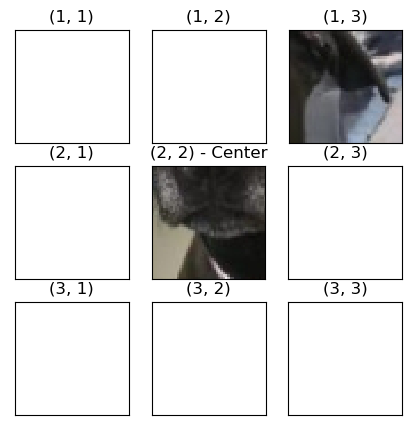

In [17]:
patch_dim = 50
gap = 30
patch_loc_arr = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)]

offset_x, offset_y = image.shape[0] - (patch_dim*3 + gap*2), image.shape[1] - (patch_dim*3 + gap*2)
start_grid_x, start_grid_y = np.random.randint(0, offset_x), np.random.randint(0, offset_y)

loc = np.random.randint(len(patch_loc_arr))
t_x, t_y = patch_loc_arr[loc]

plt.imshow(image)
plt.show()
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(5,5))
# print(ax)

for i, (tempx, tempy) in enumerate(patch_loc_arr):
    if t_x == tempx and t_y == tempy:
        tempx, tempy = patch_loc_arr[i]

        patch_x_pt = start_grid_x + patch_dim * (tempx-1) + gap * (tempx-1)
        patch_y_pt = start_grid_y + patch_dim * (tempy-1) + gap * (tempy-1)

        ax[tempx-1, tempy-1].imshow(image[patch_x_pt:patch_x_pt+50, patch_y_pt:patch_y_pt+50])
        ax[tempx-1, tempy-1].set_title(str(patch_loc_arr[i]))
        ax[tempx-1, tempy-1].set_xticks([])
        ax[tempx-1, tempy-1].set_yticks([])
    else:
        ax[tempx-1, tempy-1].set_title(str(patch_loc_arr[i]))
        ax[tempx-1, tempy-1].set_xticks([])
        ax[tempx-1, tempy-1].set_yticks([])

# Add patch to the center (Uniform patch)
patch_x_pt = start_grid_x + patch_dim * (2-1) + gap * (2-1)
patch_y_pt = start_grid_y + patch_dim * (2-1) + gap * (2-1)
ax[2-1,2-1].imshow(image[patch_x_pt:patch_x_pt+50, patch_y_pt:patch_y_pt+50])
ax[2-1,2-1].set_title(str('(2, 2) - Center'))
ax[2-1,2-1].set_xticks([])
ax[2-1,2-1].set_yticks([])

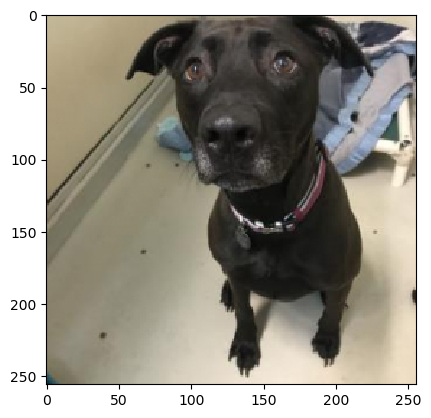

[]

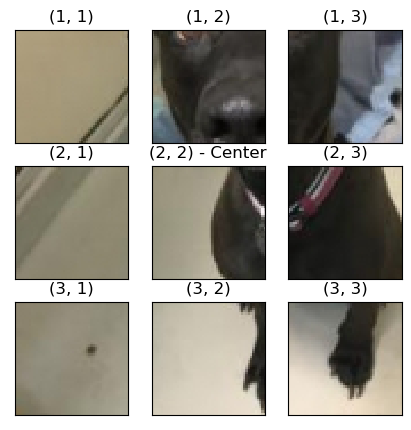

In [18]:
patch_dim = 50
gap = 30
patch_loc_arr = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)]

offset_x, offset_y = image.shape[0] - (patch_dim*3 + gap*2), image.shape[1] - (patch_dim*3 + gap*2)
start_grid_x, start_grid_y = np.random.randint(0, offset_x), np.random.randint(0, offset_y)
    
plt.imshow(image)
plt.show()
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(5,5))
# print(ax)

for i, (tempx, tempy) in enumerate(patch_loc_arr):
    tempx, tempy = patch_loc_arr[i]

    patch_x_pt = start_grid_x + patch_dim * (tempx-1) + gap * (tempx-1)
    patch_y_pt = start_grid_y + patch_dim * (tempy-1) + gap * (tempy-1)
    
    ax[tempx-1, tempy-1].imshow(image[patch_x_pt:patch_x_pt+50, patch_y_pt:patch_y_pt+50])
    ax[tempx-1, tempy-1].set_title(str(patch_loc_arr[i]))
    ax[tempx-1, tempy-1].set_xticks([])
    ax[tempx-1, tempy-1].set_yticks([])

# Add patch to the center (Uniform patch)
patch_x_pt = start_grid_x + patch_dim * (2-1) + gap * (2-1)
patch_y_pt = start_grid_y + patch_dim * (2-1) + gap * (2-1)
ax[2-1,2-1].imshow(image[patch_x_pt:patch_x_pt+50, patch_y_pt:patch_y_pt+50])
ax[2-1,2-1].set_title(str('(2, 2) - Center'))
ax[2-1,2-1].set_xticks([])
ax[2-1,2-1].set_yticks([])

In [ ]:
# os.listdir('../tiny-imagenet-200/train/n01443537/images/')

## Code

In [ ]:
class Config():
    TRAIN_PATH = '../tiny-imagenet-200/train'
    VAL_PATH = '../tiny-imagenet-200/val'
    TEST_PATH = '../tiny-imagenet-200/test'
    patch_dim = 15
    gap = patch_dim // 2
    batch_size = 16
    train_number_epochs = 100

In [ ]:
# # GIVING ERROR WHEN YOU RUN THE TRAINLOADER IN THE TRAINING LOOP
##################################################

# class SSDATASET(Dataset):
#   def __init__(self, PATH, patch_dim, gap):
#     self.PATH = PATH
#     self.patch_dim = patch_dim
#     self.gap = gap
#     self.classes = os.listdir(self.PATH)

#   def get_patch_from_grid(self, image, patch_dim, gap):
#     image = np.array(image)

#     offset_x, offset_y = image.shape[0] - (patch_dim*3 + gap*2), image.shape[1] - (patch_dim*3 + gap*2)
#     start_grid_x, start_grid_y = np.random.randint(0, offset_x), np.random.randint(0, offset_y)
#     patch_loc_arr = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)]
#     loc = np.random.randint(len(patch_loc_arr))
#     tempx, tempy = patch_loc_arr[loc]
    
#     patch_x_pt = start_grid_x + patch_dim * (tempx-1) + gap * (tempx-1)
#     patch_y_pt = start_grid_y + patch_dim * (tempy-1) + gap * (tempy-1)
#     random_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]

#     patch_x_pt = start_grid_x + patch_dim * (2-1) + gap * (2-1)
#     patch_y_pt = start_grid_y + patch_dim * (2-1) + gap * (2-1)
#     uniform_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]
    
#     random_patch_label = loc
    
#     return uniform_patch, random_patch, random_patch_label

#   def __getitem__(self, idx):
#     random_class = self.classes[idx]
#     random_class_image =  random.choice(os.listdir(os.path.join(self.PATH, random_class, 'images')))
#     print(os.path.join(self.PATH, random_class, 'images', random_class_image))

#     image = Image.open(os.path.join(self.PATH, random_class, 'images', random_class_image))
#     image = image.resize((224,224))
#     image = np.array(image).astype('uint8')

#     uniform_patch, random_patch, random_patch_label = self.get_patch_from_grid(image, self.patch_dim, self.gap)
#     print(uniform_patch.shape, random_patch.shape, random_patch_label)
#     return uniform_patch, random_patch, random_patch_label

#   def __len__(self):
#     # print(len(os.listdir(os.path.join(self.PATH, self.classes[0], 'images'))))
#     # print(len(self.classes))
#     # a, b = len(os.listdir(os.path.join(self.PATH, self.classes[0], 'images'))), len(self.classes)
#   #   print(a*b)
#     return len(self.classes)

# traindataset = SSDATASET(Config.TRAIN_PATH, patch_dim=Config.patch_dim, gap=Config.gap)
# trainloader = DataLoader(dataset=traindataset, batch_size=bs, shuffle=True)
# # print(len(trainloader))

# # valdataset = SSDATASET(PATH, val_data)
# # valloader = DataLoader(dataset=valdataset, batch_size=bs)

# # uniform_patch, random_patch, random_patch_label = next(iter(tinloader))
# # print(uniform_patch.shape, random_patch.shape, random_patch_label)

In [ ]:
# ONE WAY OF CRETING THE DATASET (BELOW IS ANOTHER WAY)
class GetPatches(object):
    def __init__(self, patch_dim, gap):
        self.patch_dim, self.gap = patch_dim, gap

    def __call__(self, sample):
        image = np.array(sample)

        offset_x, offset_y = image.shape[0] - (
            self.patch_dim * 3 +
            self.gap * 2), image.shape[1] - (self.patch_dim * 3 + self.gap * 2)
        start_grid_x, start_grid_y = np.random.randint(
            0, offset_x), np.random.randint(0, offset_y)
        patch_loc_arr = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1),
                         (3, 2), (3, 3)]
        loc = np.random.randint(len(patch_loc_arr))
        tempx, tempy = patch_loc_arr[loc]

        patch_x_pt = start_grid_x + self.patch_dim * (tempx - 1) + self.gap * (
            tempx - 1)
        patch_y_pt = start_grid_y + self.patch_dim * (tempy - 1) + self.gap * (
            tempy - 1)
        random_patch = image[patch_x_pt:patch_x_pt +
                             self.patch_dim, patch_y_pt:patch_y_pt +
                             self.patch_dim]

        patch_x_pt = start_grid_x + self.patch_dim * (2 - 1) + self.gap * (2 -
                                                                           1)
        patch_y_pt = start_grid_y + self.patch_dim * (2 - 1) + self.gap * (2 -
                                                                           1)
        uniform_patch = image[patch_x_pt:patch_x_pt +
                              self.patch_dim, patch_y_pt:patch_y_pt +
                              self.patch_dim]

        random_patch_label = loc

        if uniform_patch.shape[0] != 96:
            uniform_patch = transform.resize(uniform_patch, (96, 96))
            random_patch = transform.resize(random_patch, (96, 96))

        return uniform_patch, random_patch, random_patch_label


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        uniform_patch = sample[0].transpose((2, 0, 1))
        random_patch = sample[1].transpose((2, 0, 1))

        return uniform_patch, random_patch, sample[2]
        # return torch.from_numpy(uniform_patch).float(), torch.from_numpy(random_patch).float(), torch.from_numpy(sample[2]).long()


trainloader = torch.utils.data.DataLoader(datasets.ImageFolder(
    Config.TRAIN_PATH,
    transforms.Compose([GetPatches(Config.patch_dim, Config.gap),
                        ToTensor()])),
                                          batch_size=Config.batch_size,
                                          shuffle=True,
                                          pin_memory=True)

# data, _ = next(iter(trainloader))
# print(data[0].shape, data[1].shape, data[2])

In [ ]:
# SECOND WAY OF CREATING DATASET
##########################################

# class MyDataset(torchvision.datasets.ImageFolder):
#   def __init__(self, root, transform, patch_dim, gap):
#     super(MyDataset, self).__init__(root, transform)
#     self.patch_dim, self.gap = patch_dim, gap
  
#   def get_patch_from_grid(self, image, patch_dim, gap):
#     image = np.array(image)

#     offset_x, offset_y = image.shape[0] - (patch_dim*3 + gap*2), image.shape[1] - (patch_dim*3 + gap*2)
#     start_grid_x, start_grid_y = np.random.randint(0, offset_x), np.random.randint(0, offset_y)
#     patch_loc_arr = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)]
#     loc = np.random.randint(len(patch_loc_arr))
#     tempx, tempy = patch_loc_arr[loc]
    
#     patch_x_pt = start_grid_x + patch_dim * (tempx-1) + gap * (tempx-1)
#     patch_y_pt = start_grid_y + patch_dim * (tempy-1) + gap * (tempy-1)
#     random_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]

#     patch_x_pt = start_grid_x + patch_dim * (2-1) + gap * (2-1)
#     patch_y_pt = start_grid_y + patch_dim * (2-1) + gap * (2-1)
#     uniform_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]
    
#     random_patch_label = loc
    
#     return uniform_patch, random_patch, random_patch_label
#   def __getitem__(self, index):
#     # override ImageFolder's method
#     """
#     Args:
#       index (int): Index
#     Returns:
#       tuple: (uniform_patch, random_patch, random_patch_label) where random_patch_label will be used as target.
#     """
#     path, target = self.samples[index]
#     image = Image.open(path)

#     uniform_patch, random_patch, random_patch_label = self.get_patch_from_grid(image, self.patch_dim, self.gap)
#     return uniform_patch, random_patch, random_patch_label

# traindataset = MyDataset(Config.TRAIN_PATH, transform=None, patch_dim=Config.patch_dim, gap=Config.gap)
# trainloader = DataLoader(dataset=traindataset, batch_size=Config.batch_size, shuffle=True)

# # uniform_patch, random_patch, random_patch_label = next(iter(trainloader))
# # print(uniform_patch.shape, random_patch.shape, random_patch_label)

In [ ]:
class AlexNetwork(nn.Module):
    def __init__(self, aux_logits=False):
        super(AlexNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(96),
            nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(384),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.fc6 = nn.Sequential(
            nn.Linear(256, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
        )
        self.fc = nn.Sequential(nn.Linear(2 * 4096, 4096),
                                nn.ReLU(inplace=True), nn.Linear(4096, 4096),
                                nn.ReLU(inplace=True), nn.Linear(4096, 8))

    def forward_once(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc6(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output = torch.cat((output1, output2), 1)
        output = self.fc(output)
        return output


model = AlexNetwork().to(device)

In [ ]:
l_r = 1e-2

optimizer = optim.Adam(model.parameters(), lr=l_r)
criterion = nn.CrossEntropyLoss()

num_epochs = 3
MODEL_SAVE_PATH = os.path.join(
    'trained_models', 'model_lr' + str(l_r) + '_Adam_epochs' + str(num_epochs))

In [ ]:
global_trn_loss = []
global_val_loss = []
previous_val_loss = 100

for epoch in range(num_epochs):
    train_running_loss = []
    val_running_loss = []
    start_time = time.time()
    model.train()
    for idx, (data, _) in enumerate(trainloader):
        image1 = torch.from_numpy(np.array(data[0])).float().to(device)
        image2 = torch.from_numpy(np.array(data[1])).float().to(device)
        label = torch.from_numpy(np.array(data[2])).long().to(device)

        output = model(image1, image2)
        loss = criterion(output, label)
        train_running_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # else:
    #     model.eval()
    #     with torch.no_grad():
    #         for vdx, (inputs, labels) in enumerate(valloader):
    #             inputs, labels = Variable(inputs).to(device), Variable(
    #                 labels).to(device)

    #             outputs = model(inputs)
    #             valloss = criterion(outputs, labels)
    #             val_running_loss.append(valloss.item())

    global_trn_loss.append(sum(train_running_loss) / len(train_running_loss))
    # global_val_loss.append(sum(val_running_loss) / len(val_running_loss))

    print('Epoch [{}/{}], TRNLoss:{}, Time:{:.2f}'.format(
        epoch + 1, num_epochs, global_trn_loss[-1],
        (time.time() - start_time) / 60))

    # print('Epoch [{}/{}], TRNLoss:{}, VALLoss:{}, Time:{:.2f}'.format(
    #     epoch + 1, num_epochs, global_trn_loss[-1], global_val_loss[-1],
    #     (time.time() - start_time) / 60))

    # if global_val_loss[-1] < previous_val_loss:
    #     print('========================')
    #     print('Val Loss decreased from {} to {}'.format(
    #         previous_val_loss, global_val_loss[-1]))
    #     print('Saving model to ' + MODEL_SAVE_PATH)
    #     previous_val_loss = global_val_loss[-1]
    #     torch.save(
    #         {
    #             'epoch': epoch,
    #             'prev_valloss': previous_val_loss,
    #             'model_state_dict': model.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             'loss': loss,
    #             'global_trnloss': global_trn_loss,
    #             'global_valloss': global_val_loss
    #         }, MODEL_SAVE_PATH)
    #     print('========================')